# Import Statements

In [1]:
import scipy.io
import numpy as np

In [2]:
import pickle
import copy
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates

In [49]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils import resample

## Pull local datasets
Using only subj1 data at the moment

Test set size is: 50
Train set size is: 198
num_trials: 248 
num_feats: 2


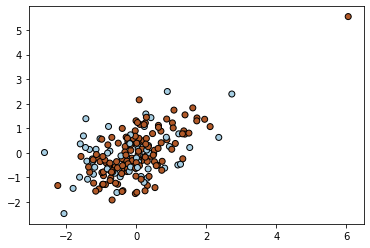

In [97]:
# EEG Data
x_train_N = scipy.io.loadmat('subj1_session1_xDataPower.mat')
x_train_N = np.asarray(x_train_N['xData1power'])
y_train_N = scipy.io.loadmat('subj1_session1_yData.mat')
y_train_N = np.asarray(y_train_N['yData1'])

# Selecting the first two features to reduce dimentionality
x_train_N = x_train_N[:,:2]

# Standardize the data set along samples
x_train_N = scale(x_train_N, axis=0)

# Create train and test set from the original data set
x_train_Tr, x_test_Ts, y_train_Tr, y_test_Ts = \
            train_test_split(x_train_N, np.squeeze(y_train_N), test_size = 0.20)



# Data details
num_trials = x_train_N.shape[0]
num_feats = x_train_N.shape[1]
print('Test set size is:',x_test_Ts.shape[0])
print('Train set size is:',x_train_Tr.shape[0])

# plot the samples
plt.scatter(x_train_Tr[:, 0], x_train_Tr[:, 1], \
            c=y_train_Tr, cmap=plt.cm.Paired, edgecolors='k')


print('num_trials:',num_trials,'\nnum_feats:',num_feats)
# print('\nx\n',x_train_N,'\ny\n', y_train_N)


# SVC using 2 first features and Class weights to handle imbalanced data

In [ ]:
# create the model
# Regularization parameter, C, has to be fine-tuned by cross-validation
SVM_clf = svm.SVC(kernel='linear')
# sweep the Regularization parameter of the mode and use 
# Cross Validation to find optimum value
CVParams = {'C':(1e-8,1e-6,1e-4,1e-2,1e-1,1,5,10,20,50,100,1000)}
CVSVM = GridSearchCV(SVM_clf, CVParams, cv=7)
# fit the model and get the separating hyperplane
CVSVM.fit(x_train_Tr, y_train_Tr)
CVSVM.best_params_

# fit the model and get the separating hyperplane using weighted classes
wSVM_clf = svm.SVC(kernel='linear', class_weight={1: 10})

# sweep the Regularization parameter of the mode and use 
# Cross Validation to find optimum value
wCVSVM = GridSearchCV(wSVM_clf, CVParams, cv=7)
# fit the model and get the separating hyperplane
wCVSVM.fit(x_train_Tr, y_train_Tr)
wCVSVM.best_params_

allscores=CVSVM.cv_results_['mean_test_score']
print(allscores)

In [ ]:
print('Number of trials is:',num_trials,'\nNumber of features is:',num_feats)
print('Test set size is:',x_test_Ts.shape[0])
print('Train set size is:',x_train_Tr.shape[0])


print('\nSVM results:\n train accuracy: %7.3f\n test accuracy:%7.3f' \
   %(CVSVM.score(x_train_Tr, y_train_Tr), CVSVM.score(x_test_Ts, y_test_Ts)))
conf_svm = confusion_matrix(y_test_Ts,CVSVM.predict(x_test_Ts))
print ('Confusion matrix for SVM (time domain):\n', (conf_svm))# + 0.0) / sum(conf_svm))
print('Classification report for SVM (time domain):\n', \
      classification_report(y_test_Ts,CVSVM.predict(x_test_Ts)))


# plot the samples
plt.scatter(x_train_Tr[:, 0], x_train_Tr[:, 1], c=y_train_Tr, cmap=plt.cm.Paired, edgecolors='k')

# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 50)
yy = np.linspace(ylim[0], ylim[1], 50)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# get the separating hyperplane
Z = CVSVM.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, levels=1, colors='k', alpha=0.5, linestyles=['-'])

# get the separating hyperplane for weighted classes
wZ = wCVSVM.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins for weighted classes
b = ax.contour(XX, YY, wZ, levels=1, colors='r', alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
           loc="upper left")
plt.show()

## Feature Reduction with PCA
Using only subj1 data at the moment

In [98]:
# EEG Data
x_train_N = scipy.io.loadmat('subj1_session1_xDataPower.mat')
x_train_N = np.asarray(x_train_N['xData1power'])
y_train_N = scipy.io.loadmat('subj1_session1_yData.mat')
y_train_N = np.asarray(y_train_N['yData1'])

# Standardize the data set along samples
x_train_N = scale(x_train_N, axis=0)
# print(x_train_N.mean(axis=0))
# Using PCA to reduce dimensionality
# Select the number of components such that the amount of variance 
# that needs to be explained is greater than 80%
pca = PCA(n_components=0.80, svd_solver='full')
x_train_N = pca.fit_transform(x_train_N)
print('Total amount of variance explained by PCA:',pca.explained_variance_ratio_.sum(axis=0))
print('Total number of features selected by PCA:',pca.n_components_)
# print(pca.mean_)

# Create train and test set from the original data set
x_train_Tr, x_test_Ts, y_train_Tr, y_test_Ts = \
            train_test_split(x_train_N, np.squeeze(y_train_N), test_size = 0.20)



# Data details
num_trials = x_train_N.shape[0]
num_feats = x_train_N.shape[1]
print('Test set size is:',x_test_Ts.shape[0])
print('Train set size is:',x_train_Tr.shape[0])

# plot the samples for top ranked components 
# plt.scatter(x_train_Tr[:, 0], x_train_Tr[:, 1], \
#             c=y_train_Tr, cmap=plt.cm.Paired, edgecolors='k')


print('Total number of Trials:',num_trials,'\nTotal number of features:',num_feats)

Total amount of variance explained by PCA: 0.8019440737127154
Total number of features selected by PCA: 41
Test set size is: 50
Train set size is: 198
Total number of Trials: 248 
Total number of features: 41


## Using RBF Kernel

In [8]:
# create the model
startTime = time.time()
# fit the model and get the separating hyperplane using weighted classes
# Regularization parameter, C, has to be fine-tuned by cross-validation
wSVM_clf = svm.SVC(class_weight='balanced')
# sweep the Regularization parameter of the mode and use 
# Cross Validation to find optimum value
CVParams = [
  {'C': [1e-6, 1e-4, 1e-2, 1e-1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1e-6, 1e-4, 1e-2, 1e-1, 1, 10, 100, 1000], \
   'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 'kernel': ['rbf']},
            ]
wCVSVM = GridSearchCV(wSVM_clf, CVParams, cv=8, n_jobs=-1)
# fit the model and get the separating hyperplane
wCVSVM.fit(x_train_Tr, y_train_Tr)
wCVSVM.best_params_

print('Total time elapsed:', time.time()-startTime)

Total time elapsed: 882.1277379989624


/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [18]:
pd.DataFrame(wCVSVM.cv_results_)

print('Number of trials is:',num_trials,'\nNumber of features is:',num_feats)
print('Test set size is:',x_test_Ts.shape[0])
print('Train set size is:',x_train_Tr.shape[0])


print('\nwSVM results:\n train accuracy: %7.3f\n test accuracy:%7.3f' \
   %(wCVSVM.score(x_train_Tr, y_train_Tr), wCVSVM.score(x_test_Ts, y_test_Ts)))

print ('Confusion matrix for wSVM (time domain):\n', \
       confusion_matrix(y_test_Ts, wCVSVM.predict(x_test_Ts)))
print('Classification report for wSVM (time domain):\n', \
      classification_report(y_test_Ts, wCVSVM.predict(x_test_Ts)))

# plt.plot(np.log(CVParams[:]['C']), wCVSVM.cv_results_['mean_test_score'], color='r')
print('Best value for C is:', wCVSVM.best_params_)
# print(wCVSVM.cv_results_)

Number of trials is: 248 
Number of features is: 41
Test set size is: 50
Train set size is: 198

wSVM results:
 train accuracy:   1.000
 test accuracy:  0.580
Confusion matrix for wSVM (time domain):
 [[ 0 21]
 [ 0 29]]
Classification report for wSVM (time domain):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.58      1.00      0.73        29

    accuracy                           0.58        50
   macro avg       0.29      0.50      0.37        50
weighted avg       0.34      0.58      0.43        50

Best value for C is: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [99]:
# Upsample minority classPython
# Separate majority and minority classes
df = pd.DataFrame(data=np.hstack([x_train_Tr,y_train_Tr.reshape(198,1)]))

# df_majority = df[df[41]==1]
# df_minority = df[df[41]==0]

df = np.hstack([x_train_Tr,y_train_Tr.reshape(198,1)])
df_majority = df[df[:,41]==1]
df_minority = df[df[:,41]==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=147,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = np.vstack([df_majority, df_minority_upsampled])
# Display new class counts
print(pd.DataFrame(data=df_upsampled)[41].value_counts())

x_train_Tr = df_upsampled[:,:-1]
y_train_Tr = df_upsampled[:,-1]

print(x_train_Tr.shape)
print(y_train_Tr.shape)

0.0    147
1.0    143
Name: 41, dtype: int64
(290, 41)
(290,)


In [101]:
# create the model
startTime = time.time()
# fit the model and get the separating hyperplane using weighted classes
# Regularization parameter, C, has to be fine-tuned by cross-validation
wSVM_clf = svm.SVC(class_weight='balanced', probability=True)
# sweep the Regularization parameter of the mode and use 
# Cross Validation to find optimum value
CVParams = [
  {'C': [1e-6, 1e-4, 1e-2, 1e-1, 1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1e-6, 1e-4, 1e-2, 1e-1, 1, 10, 100, 1000], \
#    'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 'kernel': ['rbf']},
            ]
wCVSVM = GridSearchCV(wSVM_clf, CVParams, cv=8, n_jobs=-1)
# fit the model and get the separating hyperplane
wCVSVM.fit(x_train_Tr, y_train_Tr)
wCVSVM.best_params_

print('Total time elapsed:', time.time()-startTime)

/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Total time elapsed: 7640.945449829102


In [92]:
pd.DataFrame(wCVSVM.cv_results_)

print('Number of trials is:',num_trials,'\nNumber of features is:',num_feats)
print('Test set size is:',x_test_Ts.shape[0])
print('Train set size is:',x_train_Tr.shape[0])


print('\nwSVM results:\n train accuracy: %7.3f\n test accuracy:%7.3f' \
   %(wCVSVM.score(x_train_Tr, y_train_Tr), wCVSVM.score(x_test_Ts, y_test_Ts)))

print ('Confusion matrix for wSVM (time domain):\n', \
       confusion_matrix(y_test_Ts, wCVSVM.predict(x_test_Ts)))
print('Classification report for wSVM (time domain):\n', \
      classification_report(y_test_Ts, wCVSVM.predict(x_test_Ts)))

# plt.plot(np.log(CVParams[:]['C']), wCVSVM.cv_results_['mean_test_score'], color='r')
print('Best value for C is:', wCVSVM.best_params_)
# print(wCVSVM.cv_results_)

Number of trials is: 248 
Number of features is: 41
Test set size is: 50
Train set size is: 290

wSVM results:
 train accuracy:   1.000
 test accuracy:  0.660
Confusion matrix for wSVM (time domain):
 [[ 0 17]
 [ 0 33]]
Classification report for wSVM (time domain):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.66      1.00      0.80        33

    accuracy                           0.66        50
   macro avg       0.33      0.50      0.40        50
weighted avg       0.44      0.66      0.52        50

Best value for C is: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [93]:
# Is our model still predicting just one class?
print(np.unique(wCVSVM.predict(x_test_Ts)))


df = pd.DataFrame(data=y_train_Tr)
df[0].value_counts()

[1.]


0.0    147
1.0    143
Name: 0, dtype: int64

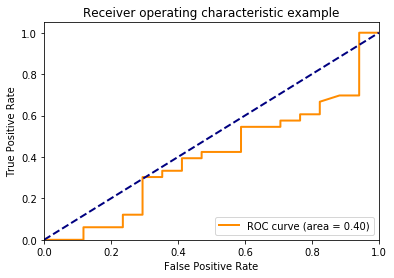

In [94]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test_Ts, wCVSVM.decision_function(x_test_Ts))
roc_auc = auc(fpr, tpr)
    

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()